In [43]:

from copy import copy
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next.particles.representation_builders import (
    ResolvedParticleMassRepresentationBuilder,
)
from particula.next.particles.distribution_builders import ParticleResolvedSpeciatedMassBuilder
from particula.next.gas.atmosphere_builder import AtmosphereBuilder
from particula.next.gas.vapor_pressure_factories import VaporPressureFactory
from particula.next.gas.species_builder import GasSpeciesBuilder
from particula.next.aerosol import Aerosol
from particula.next.dynamics import particle_process
from particula.next.dynamics.condensation import CondensationIsothermal
from particula.next.particles.activity_strategies import IdealActivityMass
from particula.next.particles.surface_strategies import SurfaceStrategyVolume
from particula.next.particles.properties.lognormal_size_distribution import lognormal_sample_distribution
from particula.next.dynamics import coagulation

In [44]:
# Glycerol gas
molar_mass_glycerol = 92.09382e-3  # kg/mol
parameters_clausius = {
    "latent_heat": 71.5 * molar_mass_glycerol,
    "latent_heat_units": "kJ/kg",
    "temperature_initial": 125.5,
    "temperature_initial_units": "degC",
    "pressure_initial": 1,
    "pressure_initial_units": "mmHg",
}
vapor_pressure_strategy = VaporPressureFactory().get_strategy(
    "clausius_clapeyron", parameters_clausius
)

sat_concentration = vapor_pressure_strategy.saturation_concentration(
    molar_mass_glycerol, 298.15
)
print(f"Saturation concentration: {sat_concentration:.2e} kg/m^3")

sat_factor = 0.50  # 50% of saturation concentration
glycerol_gas = (
    GasSpeciesBuilder()
    .set_molar_mass(molar_mass_glycerol, "kg/mol")
    .set_vapor_pressure_strategy(vapor_pressure_strategy)
    .set_concentration(sat_concentration * sat_factor, "kg/m^3")
    .set_name("Glycerol")
    .set_condensable(True)
    .build()
)

atmosphere = (
    AtmosphereBuilder()
    .add_species(glycerol_gas)
    .set_temperature(25, temperature_units="degC")
    .set_pressure(1, pressure_units="atm")
    .build()
)

# Glycerol particle distribution

particle_sample = lognormal_sample_distribution(
    mode= np.array([100e-9]),
    geometric_standard_deviation= np.array([1.3]),
    number_of_particles= np.array([1e4]),
    number_of_samples=100_000,
)

particle_mass_sample = 4 / 3 * np.pi * particle_sample ** 3 * 1260 # kg

resolved_masses = (
    ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(ParticleResolvedSpeciatedMassBuilder().build())
    .set_activity_strategy(IdealActivityMass())
    .set_surface_strategy(SurfaceStrategyVolume())
    .set_mass(particle_mass_sample, "kg")
    .set_density(1260, "kg/m^3")
    .set_charge(0)
    .set_volume(0.1, "cm^3")
    .set_mass(particle_mass_sample, "kg")
    .build()
)

aerosol = Aerosol(atmosphere=atmosphere, particles=resolved_masses)

print(aerosol.atmosphere)


Saturation concentration: 2.54e-03 kg/m^3
Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Glycerol']


Particles that coagulated: 36721


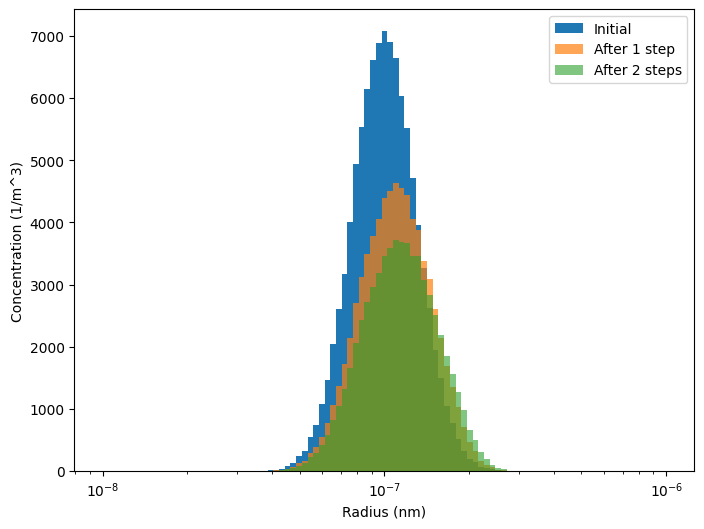

In [45]:
coagulation_strategy = coagulation.ParticleResolved()
coagulation_process = particle_process.Coagulation(coagulation_strategy=coagulation_strategy)

# Coagulation
time_step = 1000
sub_steps = 100

bins_lognormal = np.logspace(-8, -6, 100)


fig, ax = plt.subplots(figsize=(8, 6))
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(), bins=bins_lognormal
)
ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge", label="Initial")

# one step
aerosol = coagulation_process.execute(aerosol, time_step=time_step, sub_steps=sub_steps)
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(), bins=bins_lognormal
)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="After 1 step",
    alpha=0.7,
)

# step 2
aerosol = coagulation_process.execute(aerosol, time_step=time_step, sub_steps=sub_steps)
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(), bins=bins_lognormal
)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="After 2 steps",
    alpha=0.6,
)
zero_count = np.sum(aerosol.particles[0].get_mass()==0)
print(f"Particles that coagulated: {zero_count}")

ax.set_xscale("log")
# ax.set_yscale("log")
plt.legend()
ax.set_xlabel("Radius (m)")
ax.set_ylabel(f"Number of particles")
plt.show()